# Project: PI control of simple (2) wall model with windows

- Author: Glenn-Noel Bethancourt (bethagle)
- Date: 31.10.2025


# Table of Contents
- [Imports](#imports)
- [Description of Building](#description-of-building)
  - [Walls](#walls)
  - [Windows]()
  - [Air]()
- [Thermal Model]()
- [Hypothesis](#hypothesis)
- [Assembling the Model](#assembling_the_model)
  - [Matrices](#Matrices)
    - [A Matrix](#A_Matrix)
    - [C Matrix](#c-matrix)
    - [G Matrix](#g-matrix)
  - [Inputs & Outputs (b & f-vector)]()
  - [Testing]()
  - [Steady State Test](#steady-state-test)
  - [Transformation to State Space Representation](#transformation-to-state-space-representation)
    - [Eigenvalue Analysis]()
      - [step size]()
      - [settling time]()
      - [step response]()
- [Simulation](#simulation)
  - [Weather data]()
  - [Time Constant Analysis](#time-constant-analysis)
  - [Preparing Weather Data](#preparing-weather-data)
    - [Inputs and Outputs for weather data simulation]()
  - [30 day simulation]()
  - [Control]()
    - [Perfect Controller]()
    - [PI Controller](#uncontrolled-simulation-of-model)

# Imports

In [138]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Description of the building

<img src="./Design_ohne_Titel_2.png" width="400">


## Walls

- We assume that each exterior wall of the building has dimensions of **3 × 3 meters**, resulting in a total surface area of  
  $
  S_\text{total} = 9\,\text{m}^2.
  $

- Since each wall contains a window, we subtract the window area  
  $
  S_\text{window} = 1.4 \times 1.5 = 2.1\,\text{m}^2,
  $
  leading to a net exterior wall area of  
  $
  S_\text{wall} = 9 - 2.1 = 6.9\,\text{m}^2.
  $

- The wall is modeled as a two-layer construction:
  - **Layer 1 (outer layer): concrete**, representing the structural wall.  
    - conductivity: 1.70 W/(m·K)  
    - density: 2300 kg/m³  
    - specific heat: 880 J/(kg·K)  
    - thickness: 0.30 m  
    - solar absorption coefficient: α = 0.60  
  - **Layer 2 (inner layer): insulation**, representing thermal resistance.  
    - conductivity: 0.04 W/(m·K)  
    - density: 80 kg/m³  
    - specific heat: 800 J/(kg·K)  
    - thickness: 0.20 m  

- For solar modeling, we apply an absorption coefficient of  
  $\alpha_\text{wall} = 0.65$
  - https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html

In [268]:
concrete = {'Conductivity': 1.700,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.30,
            "alpha": 0.60} # absorbption coefficient

insulation = {'Conductivity': 0.040,
              'Density': 80,
              'Specific heat': 800,
              'Width': 0.20}

wall = pd.DataFrame.from_dict({'Layer_1': concrete,
                               'Layer_2': insulation},
                              orient='index')


S_wall = (3 * 3) - (1.4 * 1.5)
S_wall

wall_radiation_absorption_alpha = 0.65


## Windows

- Width: **1.40 m**
- Height: **1.50 m**
- Surface area:
  $
  A_\text{window} = 1.4 \times 1.5 = 2.10\,\text{m}^2
  $

- U-factor: **0.85 W/(m²·K)**


In [269]:
A_window = 1.4 * 1.5    # 2.10 m²
u_factor = 0.85        

## Air

- Density: **1.2 kg/m³**  

- Specific heat **1000 J/(kg·K)**  

- h_in: **5 W/(m²·K)**  
  Indoor convection coefficient
  between the inner wall surface and the indoor air.

- h_out: **10 W/(m²·K)**  
  Outdoor convection coefficient
  between the outer wall surface and the outdoor air.

- V_air: **27 m³** (from $3 \times 3 \times 3$)  
  Volume of indoor air used to compute the air’s thermal capacitance.


In [270]:
air = {'Density': 1.2, 'Specific heat': 1000, 'h_in': 5., 'h_out': 10}
air = pd.DataFrame(air, index=['Air'])
V_air = 3 * 3 * 3       # air volume

# Thermal Model <a class="anchor" id="description_of_building"></a>

<img src="./Design_ohne_Titel_3.png" width="1100">

The diagram represents the thermal network model of the 2 walls.  
Two exterior walls are shown, each consisting of an exterior convection resistance (R₀, R₅)
and two wall layers modeled as conduction resistances (R₁–R₄ for the first wall and R₆–R₉
for the second wall).

The **first wall** is represented by the temperature nodes  
θ₀ → θ₁ → θ₂ → θ₃ → θ₄  
connected through the resistances R₀, R₁, R₂, R₃, and R₄.

The **second wall** is represented by the temperature nodes  
θ₅ → θ₆ → θ₇ → θ₈ → θ₉  
connected through the resistances R₅, R₆, R₇, R₈, and R₉.

Both walls receive heat flows from solar radiation ($\dot{q}_₀$ for the first wall, $\dot{q}_1$ for the
second wall) applied at their respective exterior surface nodes. The windows are modeled
separately using resistances R₁₂ and R₁₃, which connect the outdoor temperature directly to
the indoor air node. These window resistances represent conductive heat transfer through
the glazing.

All heat-transfer paths converge at the indoor air node θ₁₀, which has a thermal capacity
representing the indoor air volume. Internal gains and the HVAC input are combined into a
single flow source and applied directly to this indoor air node.

Thermal capacities are assigned to the following nodes:
- **θ₁** and **θ₂**: outer and inner layers of the first wall  
- **θ₆** and **θ₈**: outer and inner layers of the second wall  
- **θ₁₀**: indoor air volume  

The remaining nodes have no thermal capacity.



# Hypothesis <a class="anchor" id="Hypothesis"></a>

- The 2 walls for the simulation are assumed to be located in Warsaw, Poland, using local outdoor temperature and solar radiation as external boundary conditions.
- We assume that solar radiation only passes through the walls and not the windows
- There is no occupancy


# Assembling the Model <a class="anchor" id="assembling_the_model"></a>

In this section we build the needed matrices to define to model our DAE-system

## Matrices

### A-Matrix

The matrix **A** defines the first differences and how the temperature nodes relate to each other.  
Rows **q₀–q₅** represent the wall conduction paths (upper branch), and rows **q₆–q₁₁** represent the second wall branch.  
Rows **q₁₂** and **q₁₃** correspond to the two window heat-flow paths

In [271]:
import numpy as np

# ---------------- A matrix (14 flows, 11 nodes θ0…θ10) ----------------
A = np.array([
    [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # q0  : R0  : To      -> θ0
    [-1, +1,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # q1  : R1  : θ0      -> θ1
    [ 0, -1, +1,  0,  0,  0,  0,  0,  0,  0,  0],  # q2  : R2  : θ1      -> θ2
    [ 0,  0, -1, +1,  0,  0,  0,  0,  0,  0,  0],  # q3  : R3  : θ2      -> θ3
    [ 0,  0,  0, -1, +1,  0,  0,  0,  0,  0,  0],  # q4  : R4  : θ3      -> θ4

    [ 0,  0,  0,  0,  0, +1,  0,  0,  0,  0,  0],  # q5  : R5  : To      -> θ5
    [ 0,  0,  0,  0,  0, -1, +1,  0,  0,  0,  0],  # q6  : R6  : θ5      -> θ6
    [ 0,  0,  0,  0,  0,  0, -1, +1,  0,  0,  0],  # q7  : R7  : θ6      -> θ7
    [ 0,  0,  0,  0,  0,  0,  0, -1, +1,  0,  0],  # q8  : R8  : θ7      -> θ8
    [ 0,  0,  0,  0,  0,  0,  0,  0, -1, +1,  0],  # q9  : R9  : θ8      -> θ9

    [ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0, +1],  # q10 : R10 : θ4      -> θ_air
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1, +1],  # q11 : R11 : θ9      -> θ_air

    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1],  # q12 : R12 : To_i    -> θ_air
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1],  # q13 : R13 : To_j    -> θ_air
], dtype=int)


### C-Matrix

The thermal capacities of the indoor air and the two wall layers are computed from their
material properties:

- **Air capacity:**  
  $C_{\text{air}} = \rho_{\text{air}} \cdot c_{p,\text{air}} \cdot V_{\text{air}}$

- **Wall capacities:**  
  $C_{\text{wall,1}} = \rho_{\text{wall}} \cdot c_{p,\text{wall}} \cdot d_{\text{wall}} \cdot S_{\text{wall}}$ \
  $C_{\text{wall,2}} = \rho_{\text{wall}} \cdot c_{p,\text{wall}} \cdot d_{\text{wall}} \cdot S_{\text{wall}}$

- Because we are interested in the long-term dynamics of the ""pseudo-building"", we want to avoid introducing very small time constants that would force the solver to use tiny step sizes. For this reason, we assume that windows have no thermal capacity: they do not store heat and contribute only through their thermal resistance.


Here, **C_wall_1** represents the capacity of the **outer wall layer**, while **C_wall_2** corresponds to the **inner layer / insulation** capacity.

In [272]:
C_air = air['Density'] * air['Specific heat'] * V_air  # Capacity of inner air
C_wall_1 = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall  # Outer wall layer
C_wall_2 = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall  # Inner wall / insulation

print("Thermal capacities:")
print(f"  C_air = {C_air.values} J/K")
print(f"  C_wall_1 = {C_wall_1.values} J/K")
print(f"  C_wall_2 = {C_wall_2.values} J/K")

Thermal capacities:
  C_air = [32400.] J/K
  C_wall_1 = [4189680.   88320.] J/K
  C_wall_2 = [4189680.   88320.] J/K


In [273]:
C = np.zeros(11)

- The diagonal size of the **C matrix** matches the number of temperature nodes in the model.  
- Since thermal capacities are present at nodes $\theta_1, \theta_2, \theta_3, \theta_6, \theta_8, \theta_{10}$ each capacity value is placed on the corresponding diagonal entry of $C$.


In [274]:
C[1] = C_wall_1.Layer_1.item()
C[3] = C_wall_1.Layer_2.item()
C[6] = C_wall_2.Layer_1.item()
C[8] = C_wall_2.Layer_2.item()
C[10] = C_air.item() # 0

In [275]:
# C matrix diagonals must have the same ordering as the nodes

In [276]:
C = np.diag(C)

In [277]:
pd.DataFrame(C)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,4189680.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,88320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,4189680.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88320.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### G-Matrix

The **G matrix** contains the conductances associated with each resistance in the model:

- **Index 0 and 5:** Indoor convective conductance between the indoor air and the wall surfaces, based on $h_{\text{in}}$.  
- **Indeces 1–4 and 6–9:** Conductive conductances of the wall layers, computed using  
  $G = \frac{S_{\text{wall}} \cdot \lambda_{\text{wall}}}{d_{\text{wall}}}$ 
  where *Layer 1* corresponds to the outer wall material and *Layer 2* to the insulation layer.  
- **Indexes 10–11:** Outdoor convective conductance betweem outdoor air and wall surfaces using $h_{\text{out}}$.  
- **Indeces 12–13:** Window conductances, computed as  
  $G = A_{\text{window}} \cdot U_{\text{factor}}.$  

In [278]:
G = np.zeros(A.shape[0])

# Wall 1 (top)
G[0]  = (S_wall * air["h_out"]).item()                                    # R0 : outer convection
G[1]  = ((S_wall * wall["Conductivity"]) / (wall["Width"] / 2)).Layer_1.item()  # R1
G[2]  = ((S_wall * wall["Conductivity"]) / (wall["Width"] / 2)).Layer_1.item()  # R2
G[3]  = ((S_wall * wall["Conductivity"]) / (wall["Width"] / 2)).Layer_2.item()  # R3
G[4]  = ((S_wall * wall["Conductivity"]) / (wall["Width"] / 2)).Layer_2.item()  # R4

# Wall 2 (bottom)
G[5]  = (S_wall * air["h_out"]).item()                                    # R5 : outer convection
G[6]  = ((S_wall * wall["Conductivity"]) /(wall["Width"] / 2)).Layer_1.item()  # R6
G[7]  = ((S_wall * wall["Conductivity"]) /(wall["Width"] / 2)).Layer_1.item()  # R7
G[8]  = ((S_wall * wall["Conductivity"]) /(wall["Width"] / 2)).Layer_2.item()  # R8
G[9]  = ((S_wall * wall["Conductivity"]) /(wall["Width"] / 2)).Layer_2.item()  # R9

# Inner convection wall–air
G[10] = (S_wall * air["h_in"]).item()                                     # R10 : θ4 ↔ θ_air
G[11] = (S_wall * air["h_in"]).item()                                     # R11 : θ9 ↔ θ_air

# Windows
G[12] = A_window * u_factor                                               # R12 : window 1
G[13] = A_window * u_factor                                               # R13 : window 2

G = np.diag(G)

In [279]:
pd.DataFrame(G)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,69.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000
1,0.0,78.2,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000
2,0.0,0.0,78.2,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000
3,0.0,0.0,0.0,2.76,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000
4,0.0,0.0,0.0,0.00,2.76,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000
5,0.0,0.0,0.0,0.00,0.00,69.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000
6,0.0,0.0,0.0,0.00,0.00,0.0,78.2,0.0,0.00,0.00,0.0,0.0,0.000,0.000
7,0.0,0.0,0.0,0.00,0.00,0.0,0.0,78.2,0.00,0.00,0.0,0.0,0.000,0.000
8,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,2.76,0.00,0.0,0.0,0.000,0.000
9,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,2.76,0.0,0.0,0.000,0.000


## Inputs & Outputs (b & f-vector)

### b-vector
To construct the **b vector**, we assign the outdoor temperature source $T_o$ to all  
conductances that are directly connected to the exterior.  
In our model, these correspond to the heat-flow paths through resistances  
$R_0, R_5, R_{12}, R_{13}$.  
Therefore, we place a value of **1** at the corresponding indices of the **b** vector

In [280]:
b = np.zeros(14)  # temperature sources
b[[0, 5, 12, 13]] = 1

### f-vector
For starters we assume that we have no flow sources but we will afterwards add some HVAC control through it

In [281]:
f = np.zeros(11)  # flow sources

### outputs y

For the simulations we are only interested in the inner air temperature node

In [282]:
y = np.zeros(11)      # outputs
y[10] = 1             # θ_air (inner air temperature)


## Testing

### Steady State Test


Here we compute the **steady-state temperatures** of the entire thermal network when the
outdoor temperature is set to $T_o = 1^\circ\text{C}$.  
The steady-state solution is obtained from the algebraic equation

$
\theta_{\text{steady}} 
= (A^\top G A)^{-1} \, (A^\top G\, b + f),
$

which corresponds to the condition $\dot{\theta} = 0$ in the state equation  
$C \dot{\theta} = -A^\top G A\, \theta + A^\top G\, b + f$

- The printed result shows the temperature at each node in the model, equals to the **indoor air temperature**.

In [283]:
θ_steady_To = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
np.set_printoptions(precision=3)
print('When To = 1°C, the temperatures in steady-state are:', θ_steady_To, '°C')
print(f'The indoor temperature is: {θ_steady_To[-1]:.3f} °C')

When To = 1°C, the temperatures in steady-state are: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] °C
The indoor temperature is: 1.000 °C


In [284]:
#f[-1] = 1
θ_steady_Qh = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('When Qh = 1W, the temperatures in steady-state are:', θ_steady_Qh, '°C')
print(f'The indoor temperature is: {θ_steady_Qh[-1]:.3f} °C')

When Qh = 1W, the temperatures in steady-state are: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] °C
The indoor temperature is: 1.000 °C


## State Space

For simulating now we use our defined matrices and vectors to transform it into a state space representation of it

In [285]:
from pd_dm4bem import tc2ss, read_epw, sol_rad_tilt_surf, inputs_in_time
from dm4bem import tc2ss, read_epw, sol_rad_tilt_surf

In [286]:
[As, Bs, Cs, Ds] = tc2ss(A=A, G=G, C=C, b=b, f=f, y=y)

### Eigenvalue Analysis

Before running the simulation, we must compute two important terms:

- **Step size** — the time increment used in the numerical integration.  
  It must be chosen small enough to avoid numerical instability and aliasing,  
  while still large enough to keep the simulation computationally feasable.

- **Settling time** — the warm-up period the model needs before the results become meaningful.  
  At the start of the simulation, we usually do not know the actual temperatures inside the
  walls or in the room, so the initial state vector is only a guess.  
  By simulating for a few dominant time constants, the system “forgets” this artificial
  starting point and settles into a physically consistent state.  
  After this warm-up period, the temperatures reflect the real interaction between the
  building and the weather, and we can begin the actual simulation.



In [294]:
eigenvalue, eigenvectors = np.linalg.eig(As)

#### Step size 
The eigenvalues $\lambda$ of the state matrix $A$ determine the characteristic time scales of the
thermal system.  
From these eigenvalues, we compute the corresponding **time constants**

$
\tau_i = -\frac{1}{\lambda_i},
$


For numerical stability of an explicit integration scheme, the maximum allowable time step is

$
\Delta t_{\max} = \min\!\left(-\frac{2}{\lambda_i}\right),
$

which in this case is approximately **6947.01 seconds**.  
This value provides an upper bound on the step size that can be used without risking
instability or oscillatory behavior in the simulation.


In [295]:
λ = eigenvalue
max_Δt = min(-2 / λ)

np.set_printoptions(precision=1)
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
print(f'Max time step Δt = {max_Δt:.2f} s')

Time constants: 
 [  3473.5  16805.9  25157.9 113658.9 111083.3] s 

2 x Time constants: 
 [  6947.   33611.7  50315.9 227317.9 222166.7] s 

Max time step Δt = 6947.01 s


- For simulation we set therefore the stepsize to 3000 seconds per step

In [297]:
dt = 3000
print(f'Δt = {dt} s')

Δt = 3000 s


#### Settling Time

To determine how long the system needs to reach a realistic initial condition, we compute the
**settling time** based on the slowest (largest) time constant.  

$$
t_{\text{settle}} = 4 \, \tau_{\max},
\qquad
\tau_{\max} = \max\!\left(-\frac{1}{\lambda_i}\right),
$$

which corresponds to the time required for more than 98% of the transient dynamics to decay.

The printed result shows the settling time both in seconds and in hours, indicating how long
the model must be simulated before the warm-up period can be considered complete.


The settling time is 126.29h so we need to simulate for this duration for the response to be steady state

In [298]:
# settling time
t_settle = 4 * max(-1 / λ)
print(f'Settling time: {t_settle:.2f} s = {t_settle / 3600:.2f} h')

Settling time: 454635.75 s = 126.29 h


#### step response

The plot shows the **step response** of the indoor temperature when all temperature source inputs
are subjected to a unit step.

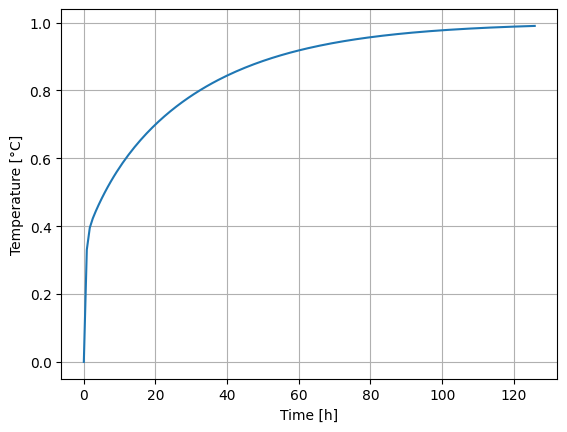

In [299]:
# number of time steps and time vector
n = int(np.ceil(t_settle / dt))
t = np.linspace(0, (n - 1) * dt, n)   # n samples

# inputs: 4 temperature sources, 2 flow sources
n_temperature_sources = 4
n_flow_sources = 0
n_inputs = n_temperature_sources + n_flow_sources

# unit step: all temperature sources = 1, all flow sources = 0
u = np.zeros((n_inputs, n))
u[:n_temperature_sources, :] = 1.0

# state and output allocation
nx = As.shape[0]
θ_exp = np.zeros((nx, n))

Ad = np.eye(nx) + dt * As
Bd = dt * Bs

for k in range(n - 1):
    θ_exp[:, k + 1] = Ad @ θ_exp[:, k] + Bd @ u[:, k]

# outputs
y_out = Cs @ θ_exp + Ds @ u

plt.plot(t / 3600, y_out.T)
plt.xlabel("Time [h]")
plt.ylabel("Temperature [°C]")
plt.grid(True)


# Simulation

## Weather data

We assume the pseudo-building is located in **Warsaw (latitude 52.23°)** with its
two walls having different orientations:

- **Wall 1:** vertical surface (slope 90°) facing **east** (azimuth 90°)  
- **Wall 2:** vertical surface (slope 90°) facing **south** (azimuth 180°)

We assum the albedo coefficient for the ground reflected solar radiation is:

- green grass: albedo = **0.25**

Using these assumptions, we compute the **tilted-surface solar radiation** for each wall and
window.


In [300]:
df, info = read_epw("weather_data/POL_Warsaw.123750_IWEC.epw")

In [301]:
df = df[["temp_air", "dir_n_rad", "dif_h_rad"]]
df.index = df.index.map(
    lambda t: t.replace(year=2000))
df.index = pd.to_datetime(df.index)


We simulate for 30 days in january

In [302]:
df = df.resample(f"{dt}s").interpolate("linear").loc["2000-01-01 01:00:00+01:00": "2000-01-30 01:00:00+01:00"]

In [303]:
df

,temp_air,dir_n_rad,dif_h_rad
2000-01-01 01:40:00+01:00,-3.133333,0.0,0.0
2000-01-01 02:30:00+01:00,-3.450000,0.0,0.0
2000-01-01 03:20:00+01:00,-3.766667,0.0,0.0
2000-01-01 04:10:00+01:00,-4.083333,0.0,0.0
2000-01-01 05:00:00+01:00,-4.400000,0.0,0.0
...,...,...,...
2000-01-29 21:20:00+01:00,1.100000,0.0,0.0
2000-01-29 22:10:00+01:00,1.050000,0.0,0.0
2000-01-29 23:00:00+01:00,1.000000,0.0,0.0
2000-01-29 23:50:00+01:00,0.833333,0.0,0.0


#### Wall 1 + window orientation

In [304]:
wall_1_surface_orientation = {'slope': 90,    
                       'azimuth': 90,
                       'latitude': 52.23}

#### Wall 2 + window orientation

In [305]:
wall_2_surface_orientation = {'slope': 90, 
                       'azimuth': 180,    
                       'latitude': 52.23}

In [306]:
df

,temp_air,dir_n_rad,dif_h_rad
2000-01-01 01:40:00+01:00,-3.133333,0.0,0.0
2000-01-01 02:30:00+01:00,-3.450000,0.0,0.0
2000-01-01 03:20:00+01:00,-3.766667,0.0,0.0
2000-01-01 04:10:00+01:00,-4.083333,0.0,0.0
2000-01-01 05:00:00+01:00,-4.400000,0.0,0.0
...,...,...,...
2000-01-29 21:20:00+01:00,1.100000,0.0,0.0
2000-01-29 22:10:00+01:00,1.050000,0.0,0.0
2000-01-29 23:00:00+01:00,1.000000,0.0,0.0
2000-01-29 23:50:00+01:00,0.833333,0.0,0.0


`sol_rad_tilt_surf` computes the **solar irradiance on a tilted surface** based on its
orientation, geographic location, and surface albedo.  
It returns three components of incident solar radiation:

- **Direct radiation** — sunlight reaching the surface directly from the sun.  
- **Diffuse radiation** — scattered sunlight from the sky dome.  
- **Ground-reflected radiation** — sunlight reflected from the ground

Together, these components describe the total solar energy incident on the
surface for each timestep.


In [307]:
weathe4wall1 = sol_rad_tilt_surf(df, wall_2_surface_orientation, albedo=0.25)
weathe4wall2 = sol_rad_tilt_surf(df, wall_1_surface_orientation, albedo=0.25)

In [308]:
weathe4wall1

,direct,diffuse,reflected
2000-01-01 01:40:00+01:00,0.0,0.0,0.0
2000-01-01 02:30:00+01:00,0.0,0.0,0.0
2000-01-01 03:20:00+01:00,0.0,0.0,0.0
2000-01-01 04:10:00+01:00,0.0,0.0,0.0
2000-01-01 05:00:00+01:00,0.0,0.0,0.0
...,...,...,...
2000-01-29 21:20:00+01:00,0.0,0.0,0.0
2000-01-29 22:10:00+01:00,0.0,0.0,0.0
2000-01-29 23:00:00+01:00,0.0,0.0,0.0
2000-01-29 23:50:00+01:00,0.0,0.0,0.0


To obtain the total solar irradiance on each wall, we sum these components

In [309]:
E_tot_1_wall = weathe4wall1.sum(1)
E_tot_2_wall = weathe4wall2.sum(1)

Absorbed solar radiation in the wall

In [310]:
Q_abs_1 = E_tot_1_wall * wall_radiation_absorption_alpha * S_wall
Q_abs_2 = E_tot_2_wall * wall_radiation_absorption_alpha * S_wall

### Inputs and Outputs for weather data simulation

In [311]:
# Inputs
b = np.zeros(14)  # temperature sources
f = np.zeros(11)  # flow sources

b[[0, 5, 12, 13]] = 1

In [312]:
f[0] = 1 # Flow source: Absorbed solar radiation of 1st wall
f[5] = 1 # Flow source: Absorbed solar radiation of 2nd wall

## 30 day Simulation 

In [313]:
[As, Bs, Cs, Ds] = tc2ss(A=A, G=G, C=C, b=b, f=f, y=y)

The indoor temperature curve **lags behind** the outdoor curve:

- When outdoor temperature rises, indoor temperature rises **later**.
- When outdoor temperature falls, indoor temperature falls **later**.

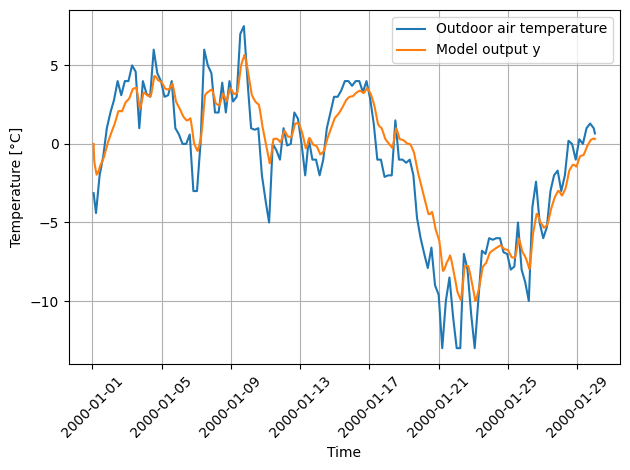

In [315]:
# extract outdoor air temperature
met = df[['temp_air']]

# time step [s] from weather data index
dt = (met.index[1] - met.index[0]).total_seconds()

# absorbed solar gains on both walls (W)
solar_rad_wall = np.vstack([Q_abs_1.values, Q_abs_2.values])  # shape: (2, N)

# 4 temperature sources: here we use the same outdoor air temperature for all 4
air_temp = np.vstack([met.values.T] * 4)  # shape: (4, N)

# build input matrix u = [temperature sources; flow sources] = (b, f)
u = np.vstack([air_temp, solar_rad_wall])  # shape: (6, N)

# number of time steps and states
n_steps = met.shape[0]
n_states = As.shape[0]

# state trajectory
θ_exp = np.zeros((n_states, n_steps))

# explicit Euler discretization
Ad = np.eye(n_states) + dt * As
Bd = dt * Bs

for k in range(n_steps - 1):
    θ_exp[:, k + 1] = Ad @ θ_exp[:, k] + Bd @ u[:, k]

# output
y_out = Cs @ θ_exp + Ds @ u   # shape: (n_outputs, n_steps)

# plotting
plt.figure()
plt.plot(met.index, met['temp_air'], label="Outdoor air temperature")
plt.plot(met.index, y_out.T, label="Model output y")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


## Control

### Perfect controller
- so far the model has been control free --> now add a controller to maintain the temperature on to a given setpoint

In [317]:
f[-1] = 1 # activate auxilary flow source for control

In [318]:
[As, Bs, Cs, Ds] = tc2ss(A=A, G=G, C=C, b=b, f=f, y=y)

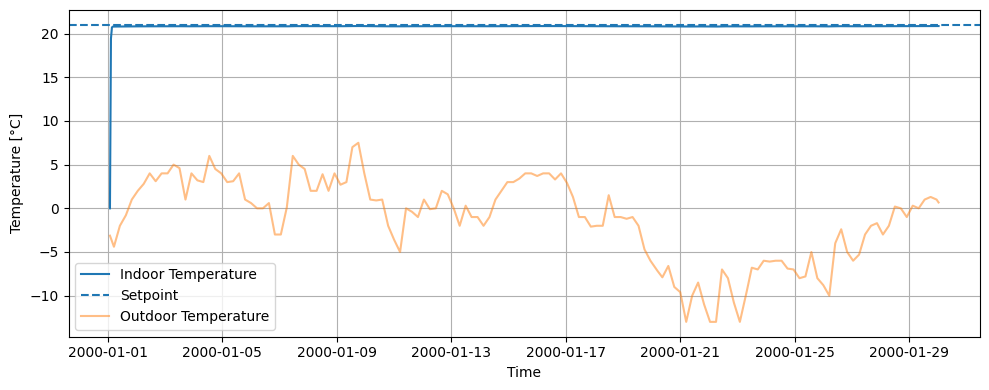

In [319]:
# --- system matrices already computed ---
# f[-1] = 1  # activate auxiliary flow source for control
# [As, Bs, Cs, Ds] = tc2ss(A=A, G=G, C=C, b=b, f=f, y=y)
# As.shape, Bs.shape, Cs.shape, Ds.shape -> (5, 5), (5, 7), (1, 5), (1, 7)

T_setpoint = 21.0
Kp = 1e3  # large gain -> "almost perfect" controller

# --- inputs: weather + solar ---
met = df[['temp_air']]  # outdoor temperature [°C]

solar_rad_wall = np.vstack([Q_abs_1.values, Q_abs_2.values])  # (2, N)
air_temp = np.vstack([met.values.T] * 4)                      # (4, N)

# stack temperature sources and solar gains
u = np.vstack([air_temp, solar_rad_wall])                     # (6, N)

# add 1 extra row for HVAC control input (aux flow source)
u = np.vstack([u, np.zeros((1, met.shape[0]), dtype=float)])  # (7, N)
hvac_idx = u.shape[0] - 1

# --- simulation setup ---
n_steps = met.shape[0]
n_states = As.shape[0]

θ_exp = np.zeros((n_states, n_steps), dtype=float)
I = np.eye(n_states)

# choose time step (seconds) – must be consistent with your discretization
dt = 30.0

# explicit Euler matrices
Ad = I + dt * As
Bd = dt * Bs

# --- simulation loop with proportional controller ---
for k in range(n_steps - 1):
    # current indoor temperature (last state component)
    T_in = θ_exp[-1, k]

    # simple P-controller: heat only when below setpoint
    if T_in < T_setpoint:
        u[hvac_idx, k] = Kp * (T_setpoint - T_in)
    else:
        u[hvac_idx, k] = 0.0

    # state update
    θ_exp[:, k + 1] = Ad @ θ_exp[:, k] + Bd @ u[:, k]

# compute output (indoor temperature) from states and inputs
y_out = Cs @ θ_exp + Ds @ u  # shape: (1, N)

# --- plots ---
plt.figure(figsize=(10, 4))
plt.plot(met.index, y_out.T, label="Indoor Temperature")
plt.axhline(T_setpoint, linestyle='--', label="Setpoint")
plt.plot(met.index, met.values, label="Outdoor Temperature", alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.tight_layout()
plt.show()


In [335]:
df, info = read_epw("weather_data/POL_Warsaw.123750_IWEC.epw")
df = df[["temp_air", "dir_n_rad", "dif_h_rad"]]
df.index = df.index.map(
    lambda t: t.replace(year=2000))
df.index = pd.to_datetime(df.index)
df = df.resample(f"{dt}s").interpolate("linear").loc["2000-01-01 01:00:00+01:00": "2000-01-02 01:00:00+01:00"]

weathe4wall1 = sol_rad_tilt_surf(df, wall_2_surface_orientation, albedo=0.25)
weathe4wall2 = sol_rad_tilt_surf(df, wall_1_surface_orientation, albedo=0.25)

E_tot_1_wall = weathe4wall1.sum(1)
E_tot_2_wall = weathe4wall2.sum(1)

Q_abs_1 = E_tot_1_wall * wall_radiation_absorption_alpha * S_wall
Q_abs_2 = E_tot_2_wall * wall_radiation_absorption_alpha * S_wall

met = df[['temp_air']]  # outdoor temperature [°C]

solar_rad_wall = np.vstack([Q_abs_1.values, Q_abs_2.values])  # (2, N)
air_temp = np.vstack([met.values.T] * 4)                      # (4, N)

### PI Controller

Since in the real world we dont have perfect controllers, we perform a control simulation where we use
a PI-Controller (Proportional–Integral)

$
u(t) = K_p\left(e(t) + \frac{1}{T_i}\int_0^t e(\tau)\, d\tau \right),
\qquad
T_i = \frac{K_p}{K_i}.
$

The controller acts on the temperature error

$
e(t) = T_{\text{set}} - T_{\text{in}}(t),
$

and generates a heating command \(u(t)\) (in watts), which is passed to the thermal model
as an auxiliary heat-flow source.  

- The **proportional term** reacts immediately to deviations from the setpoint.  
- The **integral term** accumulates error over time and removes steady-state offset.  
- When \(K_i = 0\), the controller reduces to a **P-only** controller.  
- The heating power is saturated between $P_{\min}$ and $P_{\max}$ to enforce physical limits.

To avoid wind-up, the integral term is updated only when the actuator is not saturated in
a direction that would increase the error.  

In the simulation, we sweep several values of the integral gain \(K_i\) to observe how it
affects performance. Small values of \(K_i\) lead to slow integral action, while larger
values tighten control but may introduce oscillations or instability.  

The resulting indoor temperature trajectories show how the PI controller improves tracking
of the 21 °C setpoint compared to P-only control, and the accompanying MAE plot quantifies
the effect of increasing \(K_i\).


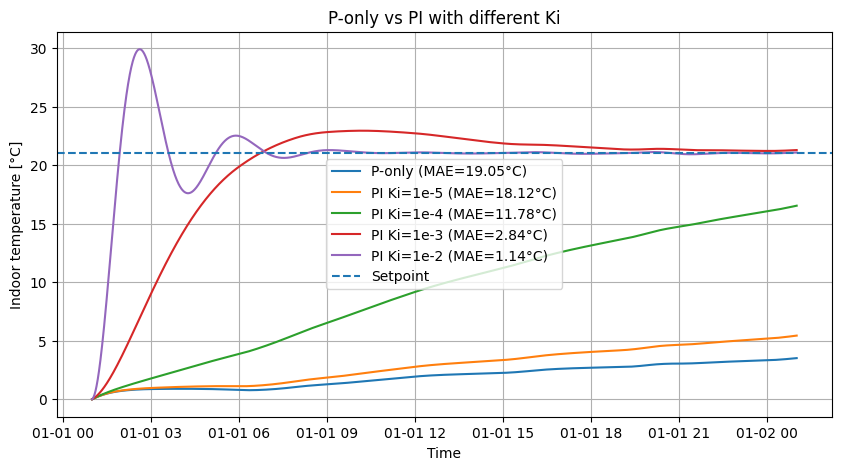

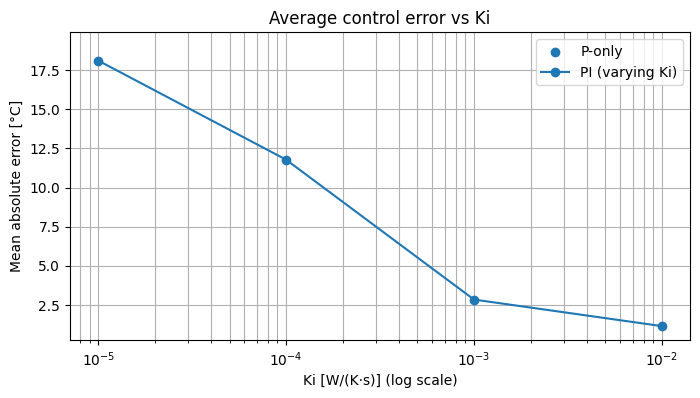

In [336]:
import numpy as np
import matplotlib.pyplot as plt


u_base = np.vstack([air_temp, solar_rad_wall])
u_base = np.vstack([u_base, np.zeros((1, met.shape[0]), dtype=float)])

i_air = -1                 
Ieye = np.eye(As.shape[0])
Pmin, Pmax = 0.0, 8000.0       
Kp = 1.1                      
Ki_sweep = [0.0, 1e-5, 1e-4, 1e-3, 1e-2]
labels = ["P-only", "PI Ki=1e-5", "PI Ki=1e-4", "PI Ki=1e-3", "PI Ki=1e-2"]

def simulate_PI(Kp, Ki, dt):
    """ISA PI: u = Kp * (e + (1/Ti) ∫e dt), with Ti = Kp/Ki; D=0."""
    Ti = np.inf if Ki == 0 else (Kp / Ki)
    theta = np.zeros((As.shape[0], met.shape[0]), dtype=float)
    u = u_base.copy()  # fresh copy per run

    I_term = 0.0
    e_prev = 0.0

    for k in range(met.shape[0] - 1):
        T_in = float(theta[i_air, k])
        e = T_setpoint - T_in

        if np.isfinite(Ti):
            I_candidate = I_term + (dt / Ti) * e
        else:
            I_candidate = I_term

        u_cmd_unsat = Kp * (e + (I_candidate if np.isfinite(Ti) else 0.0))

        u_cmd = np.clip(u_cmd_unsat, Pmin, Pmax)
        pushing_high = (u_cmd >= Pmax) and (e > 0)
        pushing_low  = (u_cmd <= Pmin) and (e < 0)
        if not (pushing_high or pushing_low):
            I_term = I_candidate

        # Apply NOW (no one-step delay)
        u[hvac_idx, k] = u_cmd

        # Plant step
        theta[:, k+1] = (Ieye + dt * As) @ theta[:, k] + dt * Bs @ u[:, k]

        e_prev = e

    T_indoor = theta[i_air, :]
    mae = float(np.mean(np.abs(T_setpoint - T_indoor)))
    return T_indoor, u[hvac_idx, :], mae


results = []
for Ki in Ki_sweep:
    T_in, u_hvac, mae = simulate_PI(Kp, Ki, dt)
    results.append({"Ki": Ki, "T_in": T_in, "u": u_hvac, "mae": mae})


plt.figure(figsize=(10, 5))
for res, lbl in zip(results, labels):
    plt.plot(met.index, res["T_in"], label=f"{lbl} (MAE={res['mae']:.2f}°C)")
plt.axhline(T_setpoint, linestyle="--", label="Setpoint")
plt.xlabel("Time"); plt.ylabel("Indoor temperature [°C]")
plt.title("P-only vs PI with different Ki")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(8, 4))
Ki_vals = [r["Ki"] for r in results]
mae_vals = [r["mae"] for r in results]

mae_ponly = mae_vals[0]
plt.scatter([0], [mae_ponly], label="P-only", zorder=3)

Ki_pos = [k for k in Ki_vals[1:]]
mae_pos = mae_vals[1:]
plt.plot(Ki_pos, mae_pos, "o-", label="PI (varying Ki)")

plt.xscale("log")
plt.xlabel("Ki [W/(K·s)] (log scale)"); plt.ylabel("Mean absolute error [°C]")
plt.title("Average control error vs Ki")
plt.grid(True, which="both"); plt.legend(); plt.show()


The first plot compares how different controllers track the indoor temperature setpoint.

- **P-only (blue):**  
  Never reaches the setpoint and stays far below it.

- **PI with small Ki (1e-5, 1e-4):**  
  Only slightly better than P-only. Still poor tracking.

- **PI with medium Ki (1e-3):**  
  Indoor temperature rises much closer to the setpoint.  
  A clear improvement over smaller Ki values.

- **PI with large Ki (1e-2):**  
  Controller becomes aggressive.  
  Overshoots the target temperature but achieves the **lowest average error**.

**Overall:** Increasing Ki improves performance, but too large Ki causes overshoot.

The second plot shows how the average tracking error changes with Ki:

- Error is **highest** for P-only.
- Error decreases as Ki increases.
- Ki = 1e-3 and 1e-2 give the **best** performance,
  with 1e-2 having the lowest error (but with overshoot).

**Conclusion:**  
A PI controller clearly outperforms P-only.  
Ki must be chosen carefully:  
- Too small → inefficient  
- Too large → overshoot  
- Around **1e-3** gives a good balance.
